## Étape 1 – Compréhension du jeu de données

### Origine des données

Les données proviennent de la plateforme data.gouv.fr et concernent l’insertion des diplômés de Master en universités et établissements assimilés. Elles sont issues d’enquêtes nationales menées par le Ministère de l’Enseignement supérieur et de la Recherche, réalisées 18 ou 30 mois après l’obtention du diplôme, selon les cohortes étudiées.


### Description générale

Le jeu de données contient des informations relatives à l’emploi (type de contrat, stabilité, temps plein), au salaire, ainsi qu’à des indicateurs contextuels régionaux tels que le taux de chômage ou le salaire médian régional.

### Variables principales

Parmi les variables disponibles figurent :
- le salaire brut annuel médian estimé,
- la part des emplois stables et à temps plein,
- la part des emplois de niveau cadre,
- le taux d’insertion,
- des variables socio-économiques régionales.

### Choix de la variable cible et objectif de modélisation

Le jeu de données porte sur l’insertion des diplômés de Master, entendue à travers plusieurs indicateurs tels que le taux d’insertion, le type d’emploi occupé, la stabilité de l’emploi et le niveau de rémunération. Il comporte 35 variables décrivant les caractéristiques des diplômés, de leur insertion ainsi que du contexte régional.

Dans ce projet, la variable cible retenue est le **salaire brut annuel médian estimé**, qui constitue un indicateur des conditions d’insertion des diplômés de Master. Ce choix permet d’analyser comment les caractéristiques de l’insertion et le contexte régional influencent le niveau de rémunération observé après l’obtention du diplôme.

L’objectif est donc de construire un modèle de **régression** visant à prédire le salaire des diplômés de Master à partir de variables liées à leur insertion et à leur environnement socio-économique.

Cette première étape permet de poser le cadre de l’analyse. Les étapes suivantes seront consacrées au nettoyage des données, à l’analyse exploratoire et à la modélisation.



## Étape 2 – Nettoyage des données

Cette étape vise à préparer le jeu de données pour l’analyse et la modélisation. Elle comprend la gestion des valeurs manquantes, la correction des formats, la détection des doublons, ainsi que la préparation des variables pour le Machine Learning.

0. Imports & configuration :

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

# Chargement du dataset
df = pd.read_csv("../data/insertion_master.csv", sep=';', encoding="latin1")

# Aperçu
df.head()

df.info()
df.shape


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19603 entries, 0 to 19602
Data columns (total 35 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   annee                                          19603 non-null  int64  
 1   diplome                                        19603 non-null  object 
 2   numero_de_l_etablissement                      19603 non-null  object 
 3   etablissement                                  19603 non-null  object 
 4   etablissementactuel                            4454 non-null   object 
 5   code_de_l_academie                             19242 non-null  object 
 6   academie                                       19242 non-null  object 
 7   code_du_domaine                                19603 non-null  object 
 8   domaine                                        19603 non-null  object 
 9   code_de_la_discipline                          196

C:\Users\matth\AppData\Local\Temp\ipykernel_65992\383990624.py:10: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/insertion_master.csv", sep=';', encoding="latin1")


(19603, 35)

Certaines variables contiennent des valeurs spéciales `ns` (non significatif) et `nd` (non disponible). Ces valeurs ont été traitées comme des valeurs manquantes.


In [3]:
# Remplacement de 'ns' et 'nd' par NaN
df.replace(["ns", "nd"], np.nan, inplace=True)

# Pourcentage de valeurs manquantes par variable
missing_percent = df.isna().mean().sort_values(ascending=False) * 100
missing_percent


taux_d_emploi_salarie_en_france                  94.536551
taux_d_emploi                                    94.536551
remarque                                         91.996123
etablissementactuel                              77.278988
salaire_net_median_des_emplois_a_temps_plein     57.843187
salaire_brut_annuel_estime                       56.924960
emplois_cadre                                    52.349130
emplois_exterieurs_a_la_region_de_luniversite    51.354385
emplois_cadre_ou_professions_intermediaires      49.926032
emplois_a_temps_plein                            49.655665
emplois_stables                                  49.318982
femmes                                           47.161149
taux_dinsertion                                  44.620721
salaire_net_mensuel_regional_1er_quartile        13.207162
salaire_net_mensuel_regional_3eme_quartile       13.207162
poids_de_la_discipline                            4.239147
salaire_net_mensuel_median_regional               2.8771

Les observations dont la variable cible est manquante ont été supprimées, car un modèle de régression nécessite une variable cible définie.

In [4]:
# Suppression des lignes où la cible est manquante
df = df.dropna(subset=["salaire_brut_annuel_estime"])

df.shape

# Liste des variables numériques importantes
numeric_cols = [
    "nombre_de_reponses",
    "taux_de_reponse",
    "poids_de_la_discipline",
    "taux_dinsertion",
    "emplois_cadre_ou_professions_intermediaires",
    "emplois_stables",
    "emplois_a_temps_plein",
    "salaire_net_median_des_emplois_a_temps_plein",
    "salaire_brut_annuel_estime",
    "de_diplomes_boursiers",
    "taux_de_chomage_regional",
    "salaire_net_mensuel_median_regional",
    "emplois_cadre",
    "emplois_exterieurs_a_la_region_de_luniversite",
    "femmes"
]

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")


Pour les variables explicatives numériques, les valeurs manquantes ont été imputées par la médiane afin de limiter l’influence des valeurs extrêmes.

In [ ]:
for col in numeric_cols:
    if col != "salaire_brut_annuel_estime":
        df[col] = df[col].fillna(df[col].median())
df.duplicated().sum()
df = df.drop_duplicates()
print("Dimensions après nettoyage :", df.shape)


La présence de valeurs extrêmes a été analysée à l’aide d’un boxplot sur la variable cible.


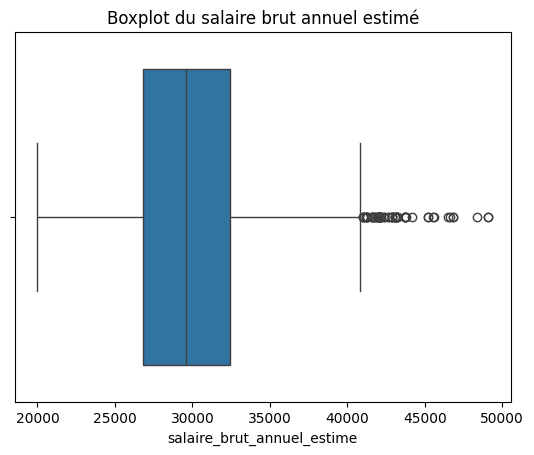

In [7]:
plt.figure()
sns.boxplot(x=df["salaire_brut_annuel_estime"])
plt.title("Boxplot du salaire brut annuel estimé")
plt.show()
categorical_cols = [
    "academie",
    "domaine",
    "discipline",
    "diplome"
]

df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)


Les variables numériques ont été standardisées afin d’assurer une meilleure convergence des modèles de régression.

In [9]:
X = df_encoded.drop("salaire_brut_annuel_estime", axis=1)

# Sélection uniquement des colonnes numériques
X_numeric = X.select_dtypes(include=[np.number])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)


In [10]:
print("Valeurs manquantes par colonne :")
print(df.isna().sum()[df.isna().sum() > 0])
print("Type de X_scaled :", type(X_scaled))
print("Forme de X_scaled :", X_scaled.shape)
pd.DataFrame(X_scaled, columns=X_numeric.columns).head()
scaled_df = pd.DataFrame(X_scaled, columns=X_numeric.columns)
print(scaled_df.describe().T[['mean', 'std']])


Valeurs manquantes par colonne :
etablissementactuel                           6001
code_de_l_academie                             361
academie                                       361
remarque                                      8261
taux_d_emploi                                 7560
taux_d_emploi_salarie_en_france               7560
salaire_brut_annuel_estime                       2
salaire_net_mensuel_regional_1er_quartile      937
salaire_net_mensuel_regional_3eme_quartile     937
id_paysage                                     361
dtype: int64
Type de X_scaled : <class 'numpy.ndarray'>
Forme de X_scaled : (8444, 15)
                                                       mean       std
annee                                         -1.315733e-14  1.000059
nombre_de_reponses                             1.430510e-17  1.000059
taux_de_reponse                                1.581976e-16  1.000059
poids_de_la_discipline                         5.385449e-17  1.000059
taux_dinsertion     

À l’issue de cette étape, le jeu de données a été nettoyé, standardisé et préparé pour la phase d’analyse exploratoire et de modélisation. Les valeurs manquantes ont été traitées, les variables catégorielles encodées et les variables numériques normalisées.